In [1]:
'''
    Author: Robert Dwyer
    Date: 10/25/2017
    A multivariate LSTM neural Network designed to predict the current days S&P500 value based on the previous days closing
    price, volume traded, and the sentiment of Donald Trump's tweets.
'''
import pandas as pd
import numpy as np
from numpy import concatenate
from numpy import sqrt
import math
from sklearn.preprocessing import Imputer
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from sklearn.model_selection import TimeSeriesSplit
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from subprocess import check_output
from numpy import newaxis
from sklearn.cross_validation import train_test_split
import matplotlib.pyplot as plt

%matplotlib inline

import time

Using TensorFlow backend.
C:\Users\bobbyd\Anaconda2\envs\neural_net\lib\site-packages\sklearn\cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [2]:
trump = pd.read_csv('trump_sent.csv')
trump.head()

,created_at,com
0,2016-01-01,6.4942
1,2016-01-02,2.8296
2,2016-01-03,0.1894
3,2016-01-04,2.0465
4,2016-01-05,8.0538


In [3]:
nyse = pd.read_csv('C:/Users/bobbyd/Desktop/data_science/git_repo/Trump-and-the-Stock-Market/nyse1.csv', skipfooter=2, engine = 'python')
nyse.head()

,Date,Open,Low,High,Close,Volume
0,"Aug 22, 2017",2433.75,2433.67,2454.77,2452.51,"1,588,714,000"
1,"Aug 18, 2017",2427.64,2420.69,2440.27,2425.55,"1,962,081,000"
2,"Aug 17, 2017",2462.95,2430.01,2465.02,2430.01,"1,929,351,000"
3,"Aug 15, 2017",2468.66,2461.61,2468.90,2464.61,"1,689,634,000"
4,"Aug 14, 2017",2454.96,2454.96,2468.22,2465.84,"1,586,224,000"


In [4]:
#preprocess Stock data
nyse.index = pd.DatetimeIndex(nyse['Date'])
nyse.sort_index(ascending=True, inplace=True)
nyse.drop('Date', axis=1, inplace=True)
nyse = nyse[['Close','Volume']]
nyse = nyse.resample('D').fillna('ffill')
nyse['Volume'] = nyse['Volume'].apply(lambda x: x.replace(',', ''))
nyse= nyse.loc['2016-01-01':, :]
nyse.head()

,Close,Volume
Date,,
2016-01-01,2043.94,482596000
2016-01-02,2043.94,482596000
2016-01-03,2043.94,482596000
2016-01-04,2012.66,802072000
2016-01-05,2012.66,802072000


In [5]:
#preprocess sentiment data
trump.index = pd.DatetimeIndex(trump['created_at'])
trump.sort_index(ascending=True, inplace=True)
trump.drop('created_at', axis=1, inplace=True)
trump=trump.loc[:'2017-08-22',:]

In [6]:
trump.shape, nyse.shape

((600, 1), (600, 2))

In [7]:
df=pd.concat([nyse, trump], axis=1)
df = df.rename(columns={'com': 'sentiment'})
df.head()

,Close,Volume,sentiment
2016-01-01,2043.94,482596000,6.4942
2016-01-02,2043.94,482596000,2.8296
2016-01-03,2043.94,482596000,0.1894
2016-01-04,2012.66,802072000,2.0465
2016-01-05,2012.66,802072000,8.0538


In [12]:
imputer = Imputer(strategy='median')
df = imputer.fit_transform(df)

In [13]:
#A function that will covert a time series database into a supervised learning database

def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
    n_vars = 1 if type(data) is list else data.shape[1]
    df = pd.DataFrame(data)
    cols, names = list(), list()
    # input sequence (t-n, ... t-1)
    for i in range(n_in, 0, -1):
            cols.append(df.shift(i))
            names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
    # forecast sequence (t, t+1, ... t+n)
    for i in range(0, n_out):
        cols.append(df.shift(-i))
        if i == 0:
            names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
        else:
            names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
    # put it all together
    agg = pd.concat(cols, axis=1)
    agg.columns = names
    # drop rows with NaN values
    if dropnan:
        agg.dropna(inplace=True)
    return agg


df = df.astype('float32')



# scale data, reframe for supervised learning and drop target variable
scaler = MinMaxScaler(feature_range=(0,1))
scaled  = scaler.fit_transform(df)
reframed = series_to_supervised(scaled, 1, 1)
reframed.head()
reframed.drop(reframed.columns[[3,4]], axis=1)
reframed.head()

,var1(t-1),var2(t-1),var3(t-1),var1(t),var2(t),var3(t)
1,0.331191,0.063974,0.530415,0.331191,0.063974,0.377457
2,0.331191,0.063974,0.377457,0.331191,0.063974,0.267257
3,0.331191,0.063974,0.267257,0.282975,0.156613,0.344771
4,0.282975,0.156613,0.344771,0.282975,0.156613,0.595512
5,0.282975,0.156613,0.595512,0.248447,0.137112,0.370395


In [14]:
#split data into training and test
values= reframed.values
n_train_hours =30*10
train = values[:n_train_hours, :]
test = values[n_train_hours:,:]

#split data into inputs and outputs
train_X, train_y = train[:,:-1], train[:,-1] 
test_X, test_y = test[:,:-1], test[:,-1]

#required input shape for a LSTM is 3D
train_X = train_X.reshape(train_X.shape[0],1, train_X.shape[1])
test_X = test_X.reshape(test_X.shape[0],1, test_X.shape[1])
print(train_X.shape, train_y.shape, test_X.shape, test_y.shape)

(300, 1, 5) (300,) (299, 1, 5) (299,)


Train on 300 samples, validate on 299 samples
Epoch 1/50
300/300 [==============================] - 0s - loss: 0.3480 - val_loss: 0.2972
Epoch 2/50
300/300 [==============================] - 0s - loss: 0.3158 - val_loss: 0.2457
Epoch 3/50
300/300 [==============================] - 0s - loss: 0.2837 - val_loss: 0.1934
Epoch 4/50
300/300 [==============================] - 0s - loss: 0.2513 - val_loss: 0.1400
Epoch 5/50
300/300 [==============================] - 0s - loss: 0.2185 - val_loss: 0.0920
Epoch 6/50
300/300 [==============================] - 0s - loss: 0.1859 - val_loss: 0.0675
Epoch 7/50
300/300 [==============================] - 0s - loss: 0.1559 - val_loss: 0.0800
Epoch 8/50
300/300 [==============================] - 0s - loss: 0.1312 - val_loss: 0.1166
Epoch 9/50
300/300 [==============================] - 0s - loss: 0.1136 - val_loss: 0.1614
Epoch 10/50
300/300 [==============================] - 0s - loss: 0.1042 - val_loss: 0.1994
Epoch 11/50
300/300 [======================

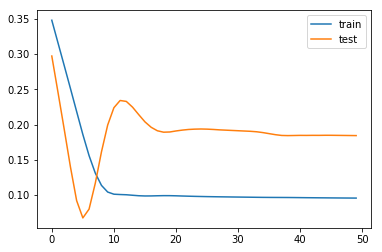

In [16]:
'''
    LSTM will defined with 1 hidden layer composed of 50 neurons and 1 output layer composed of 1 neuron

'''
# Design network
model =Sequential()
model.add(LSTM(50, input_shape=(train_X.shape[1], train_X.shape[2])))
model.add(Dense(1))
model.compile(loss='mae', optimizer='adam')

#fit network
history = model.fit(train_X, train_y, epochs=50, batch_size=72, validation_data=(test_X, test_y), verbose=1, shuffle=False)

#plot history
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()
plt.show()

In [17]:
#predict values and calculate Root Mean Squared Error score
yhat = model.predict(test_X)
rmse = sqrt(mean_squared_error(test_y, yhat))
rmse

0.20568059